In [398]:
import pandas as pd
import numpy as np
import KAsql2 as ka

import seaborn as sns
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
from pandas.tools.plotting import scatter_matrix

import statsmodels.api as sm
from sklearn.decomposition import PCA
#from sklearn import linear_model

import cPickle as pickle
from gensim import models

%matplotlib inline

In [386]:
def get_stars():
    sql = 'SELECT id, business_id, stars FROM ortho.review;' 
    rows = ka.query_SQL(sql)# extracts unique yelp_ids
    df = pd.DataFrame(np.array(rows),columns=['RID','BID','rstars'])
    return df

In [387]:
def regress(df):  
    # Fit a regression model of topics predicting stars
    y = df.rstars
    topics = df.columns.values.tolist()[3:]
    X = df.loc[:,topics]
    X = sm.tools.tools.add_constant(X,True)
    regr = sm.OLS(y, X).fit()# get reg object    
    return regr

In [388]:
def find_sign_predictors(regr):
    sign_topics = []#print 'Topic, Beta, p-value'
    for i in range(0,30):
        B = np.round(regr.params[i], decimals=3)
        p = np.round(regr.pvalues[i], decimals=3)
        if p<=.05:
            #print i, B, p 
            sign_topics.append([i,B,p])
    return sign_topics

In [389]:
def load_lda():
    lda = pickle.load(open('lda_ortho_30t_pos.p','rb'))
    #lda.show_topics(5)
    return lda

In [390]:
def topic_num_to_word(lda):
    # Obtain the words that characterize each topic (using the lda model object)
    
    #Initialize
    SELECTED = np.arange(0,30)#all 30 topics
    NWORDS_SHOWN = 10#limit to top ten words
    topic_word_df=pd.DataFrame()

    #temp_df is a df containing words for a single topic, which gets appended to final df, and reused for each loop cycle
    for sel_topic in SELECTED:
        topic = lda.show_topic(sel_topic, NWORDS_SHOWN)#type list
        temp_df=pd.DataFrame([(tup[1].encode("utf-8").replace(',','')) for tup in topic]).transpose()#got strange error trying to make transpose a separate line of code... 

        # Add the Topic # in a column at the beginning, and append to master DF
        topic_word_df = topic_word_df.append([temp_df],ignore_index=True)

    topic_word_df.insert(0,'Topic',SELECTED)
    return topic_word_df 

In [391]:
def get_lowstar_words(topic_word_df, sign_topics):
    topics = []
    words_df = pd.DataFrame()
    for st in sign_topics:
        words = topic_word_df.loc[st[0],:]
        words_df =words_df.append(words, ignore_index=True)
        topics.append(st[0])
    return words_df, topics

In [409]:
def convert_rgb(org_color):   
    """org_color is type string: '174.199.232'
    # Original values are scaled 1-255
    # rgb_color is type tuple
    # Final color is scaled 0-1: (0.643,0.416,0.894)"""
    
    str_vec = org_color.strip().split('.')#type list - of strings
    num_vec = [float(s) for s in str_vec]#type list - of floats
    rgb_scale = [(n/255) for n in num_vec]#type list - of scaled floats
    
    # Note: Tried a regular expression...
    # It doesn't work - e.g.,:  t2 = [t[i] for i in t]
    # TypeError: tuple indices must be integers, not float
    rgb_tuple = (rgb_scale[0],rgb_scale[1],rgb_scale[2])
    return rgb_tuple
    

In [417]:
def tableau():
    """ returns a dict with color names as keys and converted rgb tuples as values
    #http://tableaufriction.blogspot.ro/2012/11/finally-you-can-use-tableau-data-colors.html
    #References convert_rgb()"""

    tableau={}#dict
    color_key = [
    'dark_grey','med_grey','med2_grey','med3_grey','med4_grey','light_grey',
    'blue','orange','green','red','purple',
    'turq','puke','med_puke','light_puke',
    'brown','lav',
    'dark_red','bright_red','fushia_red','salmon','blue_red','light_red',
    'cool_blue','purp_blue','med_blue','med2_blue','med3_blue',
    'lav_blue','sky_blue','light_cool_blue']
    color_str = [
    '50.50.50','75.75.75','100.100.100','125.125.125','150.150.150','200.200.200',
    '31.119.180','255.127.14','44.160.44','214.39.40','148.103.189',
    '23.190.207','188.189.34','205.204.93','219.219.141',
    '140.86.75','227.119.194',
    '177.3.24','240.39.32','189.10.54','242.108.100','177.3.74','254.69.70',
    '44.105.176','144.158.206','107.163.214','137.183.214','95.158.209',
    '181.200.226','177.213.240','94.155.225']
    
    for idx in range(0,len(color_key)):
        #print(color_str[idx])
        tup = convert_rgb(color_str[idx])
        #tableau[color_key[idx]] = color_str[idx]
        tableau[color_key[idx]] = tup
    
    #For Displaying/debugging
    #print(tableau.items())
    #print(tableau['dark_grey'])#access by color-name
    return tableau

In [463]:
class color:
    """ Class that defines colors in a palette for a bar graph"""
    t = tableau()#color settings

    c = [ t['cool_blue'],t['red'] ]#marker color: 0=healthy/control and 1=sick/target groups
    err = [ t['med2_grey'],t['med2_grey'] ]#error bar color
    edge = [ t['med2_grey'] ]
    
    xlb = t['dark_grey']; ylb = t['dark_grey']#labels
    xtk = t['med2_grey']; ytk = t['med2_grey']#ticks
    ytl = t['med2_grey']#ticklines
    leg = t['dark_grey']#legend box
    box = t['med4_grey']

In [452]:
#     # Reduce dimensionality of four topics into 1 factor using PCA
#     pca = PCA(n_components=1)
#     pca.fit(low_star_top)
#     print('\nPCA: % Variance Explained: ',np.round(pca.explained_variance_ratio_*100,3))
#     # components are eigenvectors
#     EV = np.round((pca.components_),5).T

#     # PROJECTED Topics
#     # Use this d x k eigenvector matrix to transform the original samples onto the component subspace. 
#     # Arg for transform is projected on the principal components extracted from the training set
#     X_pca = pca.transform(low_star_top)# topics mapped onto new feature space
    
    # Plot topic by Rstars
    #xlabel='PCA 1';ylabel='Rstars'   

In [453]:
#     # Transform columns sign associated with low stars to improve distribution
#     low_star_top = np.asarray(Reviews_topics_df.loc[:,topics])
#     low_star_top_T = np.log(low_star_top*100)
#     print low_star_top_T
#     print 'shapes: ',np.shape(low_star_top), np.shape(low_star_top_T)
#     print'hist'
#     fig = np.histogram(low_star_top_T, bins=10)
#     plt.show()

In [454]:
    ### PLOTS
    # Histograms/boxplots
#     fig1 = merge_df.boxplot(column=[10], by=['rstars'], figsize=(6,3))
#     plt.show()
    
#     fig2 = Reviews_topics_df.loc[:,topics].plot(kind='hist',alpha=.5, stacked=True)
#     plt.show()
    
    # Scatterplot
#     X=Reviews_topics_df.loc[:,10].values
#     Y=merge_df.rstars.values
#     ax = sns.regplot(x=X, y=Y, marker='+',color='b')
#     ax.set_xlabel('Topic: Time/Appointment-Based Hassles')
#     ax.set_ylabel('Review Stars')

    # There work but they aren't nice looking
    #df.plot(x='ht0',y='wt0',marker='o',lw=0)
    #seaborn_graph(X,Y)

In [455]:
def dichtomoize_stars(merge_df, topics):
    # Return 
    low_idx = merge_df[merge_df.rstars.values<=2].index
    high_idx = merge_df[merge_df.rstars.values>=4].index
    
    col= [t+3 for t in topics]#offset otherwise it chooses col-index, which doesn't match topic number
    low = merge_df.loc[low_idx, col]
    low.insert(0,'dstar','low')
    high = merge_df.loc[high_idx, col]
    high.insert(0,'dstar','high')
    
    dstar_df = pd.concat([low,high], axis=0, join='outer', ignore_index=False)

    return dstar_df

In [456]:
def seaborn_graph(x,y):
    print('My first graph\n')
    sns.set(style="ticks")
    
    fig = sns.jointplot(x, y, kind="hex", stat_func=kendalltau, color="#008A00")   
    fig.set_axis_labels('Topics','Stars', fontsize=30)
    plt.show()

In [469]:
# def seaborn_bar(dstar_df):
#     Bar Plot
#     ax = sns.barplot(x='dstar',y=15, data=dstar_df)
#     ax2 = sns.barplot(x=dstar_df.dstar, y=dstar_df.loc[:,3], palette="RdBu_r")
#     ax2.set_xlabel("Low versus High Stars")
#     ax2.set_ylabel("Topic Score: Hassles - Time/Insurance", fontsize=16)
#     #sns.despine(bottom=True)

In [484]:
def ka_bar(dstar_df, c, ka_labels, topics, legend_labels, p):
    """Plot a bar-graph of two groups with multiple DVs"""
    ind = np.arange(4)#This may throw error if emmeans has only one DV
    width = .35
    
    # Instatiate objects
    fig, ax = plt.subplots()
    
    # Means and SEM
    low_means = dstar_df[dstar_df.dstar=='low'].mean()
    high_means = dstar_df[dstar_df.dstar=='high'].mean()
    low_sem = dstar_df[dstar_df.dstar=='low'].sem()
    high_sem = dstar_df[dstar_df.dstar=='high'].sem()

    # Plot data as bars
    rects1 = ax.bar(ind, low_means, width, color=c.c[0],yerr=low_sem ,ecolor = c.err[0],edgecolor=c.edge)
    rects2 = ax.bar(ind+width, high_means, width, color=c.c[1],yerr=high_sem,ecolor=c.err[1], edgecolor=c.edge)
    
    # Format axes labels, ticks, and lines
    plt.rc('axes',ec=c.box)
    ax.set_xlabel(ka_labels[0], fontsize=16, color=c.xlb)
    ax.set_ylabel(ka_labels[1], fontsize=16, color=c.ylb)
    #ax.set_title('FA Means by Group')
    ax.set_xticks(ind+width)
    ax.set_xticklabels(topics,fontsize=12, color=c.xtk)
    plt.setp([ax.get_yticklabels()], fontsize=12, color=c.ytk)
    
    plt.setp([ax.get_xticklines()], visible=False)
    plt.setp([ax.get_yticklines()], visible=False)
    
    # Max & min values for Y-axis
    #plt.ylim([np.min(X), np.max(X)])#good to start with
    
    # Set Legend
    leg = ax.legend( (rects1[0], rects2[0]), (legend_labels[0],legend_labels[1]), loc="upper left", fontsize=14)
    leg.get_frame().set_edgecolor(c.box)
    for text in leg.get_texts():
        plt.setp(text, color=c.leg)
    
    # Add p-values as a text annotation
#     for i in range(0, 4):  
#         # These if statements just help me tailor the placement of these p-values
#         # otherwise, they can be commented out
#         if i==0: ypad = 2.1
#         else: ypad = 3
#         xpad = 0
#         #xpad = .3*width
#         #yloc_p = max(low_means,high_means) + (ypad*max(low_sem,high_sem))
#         ax.text(ind[i]+xpad, .90, p[i], fontsize=8.5, color=c.xtk)
    
    #ax.margins(0.05)
    plt.show()
    return fig

USE ortho;
[[3, -2.069, 0.048000000000000001], [10, -3.3679999999999999, 0.001], [11, -2.6179999999999999, 0.012], [15, -2.8500000000000001, 0.0060000000000000001]] 

        0        1            2            3       4          5       6  \
0    time      mri    insurance       injury    need      never   going   
1    told     said  appointment         time  called  insurance  office   
2    time  minutes  appointment         wait   didnt    patient  office   
3  office     time         told  appointment    even      staff    dont   

       7      8       9  Topic  
0   even   call  office      3  
1    mri  didnt  really     10  
2  staff  never   great     11  
3   care   said  really     15   



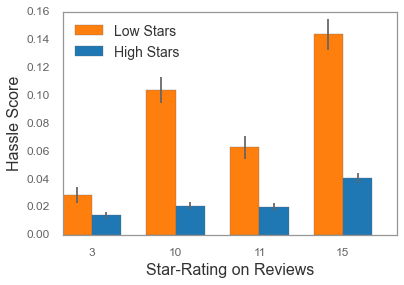

In [489]:
def main():   
    
    # Load data with RID, BID and topic weights - merge with review-stars
    Reviews_topics_df = pd.read_pickle('Review_topics_df.p')
    star_df = get_stars()#queries MySQL for review star data
    #merge_df = pd.concat([star_df,Reviews_topics_df], axis=1)# this duplicates the ID columns
    merge_df = star_df.merge(Reviews_topics_df, how='inner', on=['RID','BID'], left_index=True, copy=True)
    merge_df.to_csv('Stars_topics.csv')
    
    # Fit regression model of topics predicting stars
    regr = regress(merge_df)
    #print regr.summary()
    
    #Determine what words correspond to topics that are negatively correlated with stars
    lda = load_lda()
    topic_word_df = topic_num_to_word(lda)#print 'Topic, Beta, p-value'
    sign_topics = find_sign_predictors(regr)# sign_topics is a list of lists: each list - topic, beta, p-value
    print sign_topics,'\n'
    
    # For interpretation: Create a DF of the words related to topics negatively related to stars
    words_df, topics = get_lowstar_words(topic_word_df,sign_topics)
    print words_df,'\n'

    # dichotomize stars
    dstar_df = dichtomoize_stars(merge_df, topics)
    
    # Bar Graph
    t = tableau()
    palette = color() 
    palette.c = [ t['orange'], t['blue'] ]
    axis_labels = ["Star-Rating on Reviews","Hassle Score"]
    legend_labels = ["Low Stars","High Stars"]
    p = ['.048*','.001**','.012*','.006**']
    
    ka_bar(dstar_df, palette, axis_labels, topics, legend_labels, p)
    
if __name__=="__main__":
    main()